<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/OptimalSwitching_SHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><font size='5'><b>Optimal Switching: Selective Harmonic Elimination</font></b>

Dr. Bingsen Wang

12/3/2023
</center>

#Background

Without loss of generality, a square waveform with firing angle $\theta$ only has the Fourier coefficients for the sine terms.
$$b_n = \frac{4}{n\pi}\cos(n\theta)\tag{1}$$

If the square waveform has an additional firing angle to create a "notch", then the Fourier coefficient for the fundamental component is given by
$$b_1 = \frac{4}{\pi}(\cos\theta_1 - \cos\theta_2)\tag{2}$$
Due to the extra freedom with the firing angle $\theta_2$, an additional constraint can be satisfied, for instance, to eliminate the fifth-order harmonic, i.e.
$$b_5 =0 = \frac{4}{5\pi}[\cos(5\theta_1) - \cos(5\theta_2)]\tag{3}$$

#Python Code
The Python code illustrates the waveform spectrum by varying firing angle $\theta_1$ with keeping the constraint in (3).

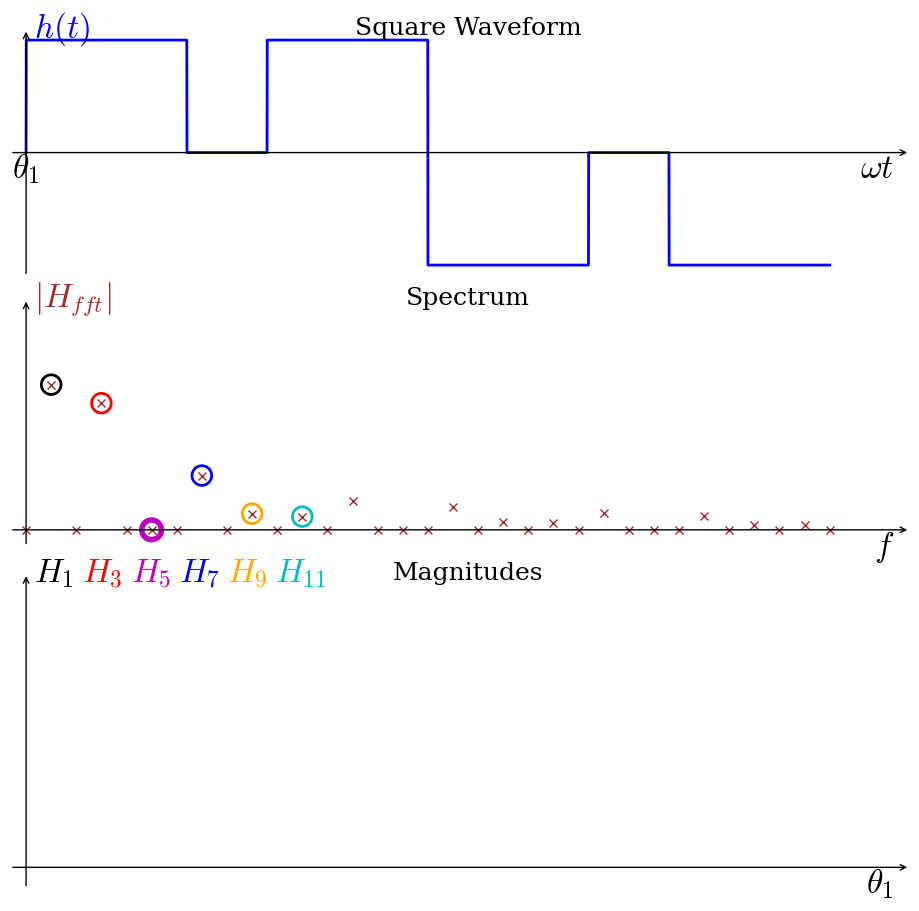

In [31]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,array,fft,abs, angle,sqrt,c_
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def h(theta,t): #square waveform with one firing angle theta
  return (2*heaviside(sin(2*pi*t),0)-1)*heaviside(abs(sin(2*pi*t))-sin(theta),0)

#spectrum
def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

#parameters
Nf = 250 # number of frames
Np = 4096 # number of points
theta1_v = linspace(0,pi/2 - 2*pi/5,Nf) #firing angle 1
theta2_v = theta1_v + 2*pi/5 #firing angle 2 to eliminate 5th-order harmonic

#time series
t = linspace(0,1,Np)

#spectrum and frequency series
fser = linspace(0,1,33) #frequency series for plotting
fser_sliced = fser[1:13:2]

ht = []
hfft = []
for k in range(Nf):
  htk = h(theta1_v[k],t) - h(theta2_v[k],t)
  ht.append(htk)
  hfft.append(spectrum(htk))

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, .7, 1, .275], [-.02,1.1], [-1.1, 1.1]], #sine1 & triangle
            [[0, .4, 1, .275], [-.02,1.1], [-.1, 1.4]], #sine2 & triangle
            [[0, 0.02,  1, .35], [-.02,1.1], [-.1,1.4]], # ac output spectrum
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$h(t)$'], r'$\omega t$'],
        [['$|H_{fft}|$'], '$f$'],
        [[r'$H_{1}$','$H_{3}$','$H_{5}$','$H_{7}$','$H_{9}$','$H_{11}$'], r'$\theta_1$'],
        ] #yx axes labels
title_lst = ['Square Waveform',
             'Spectrum',
             'Magnitudes',
             ]
clst=[['b'], ['brown'], ['k','r','m','b','orange','c']] #colors of lines
ax_lst=[] #axis list or the list of subplots
tx_lst=[]
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  for i in range(len(ax_lbl[k][0])):
    y_text=ax.text(0.01+0.06*i,ym,ax_lbl[k][0][i],size=24,va='center',color=clst[k][i]) #y label
    if k==1:
      lines.append(ax.plot([], [], clst[k][i], ls='',marker='x',markersize=6)[0])
      lines.append(ax.scatter(fser_sliced, fser_sliced*0,s=200,ec=clst[-1],
                              marker='o',fc='none',lw=[2,2,4,2,2,2])) #circle H1,3,5,7,9,11
    else:
      lines.append(ax.plot([], [], clst[k][i], lw=2)[0])
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  tx_lst.append(ax.text(0.55,ax_frame[k][2][1],title_lst[k],color='k',
                        va='center',ha='center',size=18))
tx_firingAngle1 = ax_lst[0].text(0,0,r'$\theta_1$',size=24,va='top',ha='center') #theta1 label
tx_firingAngle2 = ax_lst[0].text(0.2,0,r'$\theta_2$',size=24,va='top',ha='center') #theta2 label

# animation function. This is called sequentially
def animate(i):
  hti = ht[i]
  hffti = hfft[i]
  hfft_sliced = hffti[0][1:13:2]
  tx_firingAngle1.set_position([theta1_v[i]/(2*pi),0])
  if theta2_v[i] == pi/2:
    tx_firingAngle2.set_text('')
  else:
    tx_firingAngle2.set_position([theta2_v[i]/(2*pi),0])
  lines[0].set_data(t,hti) #ac output
  lines[1].set_data(fser,hfft[i][0][:len(fser)]) #spectrum
  lines[2].set_offsets(c_[fser_sliced,hfft_sliced]) # marked components
  for k in range(6):
    lines[3+k].set_data(theta1_v[0:i]/(pi/2-2*pi/5),array(hfft)[0:i,0,2*k+1]) #magnitudes
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"OptimalSwitching_SHE.mp4"
writervideo = animation.FFMpegWriter(fps=25)
anim.save(fn, writer=writervideo,dpi = 120)